# Topik: Analisis Sentimen Opini Publik terhadap Kebijakan Pemindahan Dana Rp 200 Triliun ke Bank Himbara oleh Menteri Keuangan Purbaya melalui Komentar YouTube

## Notebook: Modeling dan Evaluasi Model Klasifikasi Sentimen

**Anggota Kelompok:**  
- 140810230011 - Lukas Austin  
- 140810230045 - Devin Suryadi  
- 140810230057 - Orlando Bloem Sutono  

Mata Kuliah: Data Mining  
Kelas: A  
Dosen: Bu Helen

---

**Metodologi:**
1. **Classical Machine Learning**: SVM dan XGBoost dengan TF-IDF, optimasi menggunakan K-Fold Cross Validation pada data train.
2. **Evaluasi**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix.

## 1. Import Library
Library yang dibutuhkan untuk modeling dan evaluasi.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, precision_score, recall_score, precision_recall_fscore_support
)
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_colwidth', 200)

print("Library berhasil dimuat!")

Library berhasil dimuat!


## 2. Load Dataset
Memuat dataset hasil preprocessing yang sudah dilabeli.

In [5]:
# Load dataset
df = pd.read_csv("dataset_labeled.csv")

print(f"Dataset dimuat: {len(df)} baris")
print(f"Kolom: {list(df.columns)}")
print(f"\nDistribusi sentimen:")
print(df['sentiment'].value_counts())
print(f"\nPersentase:")
print(df['sentiment'].value_counts(normalize=True) * 100)

df.head()

Dataset dimuat: 924 baris
Kolom: ['comment', 'sentiment']

Distribusi sentimen:
sentiment
Positif    435
Negatif    334
Netral     155
Name: count, dtype: int64

Persentase:
sentiment
Positif    47.077922
Negatif    36.147186
Netral     16.774892
Name: proportion, dtype: float64


,comment,sentiment
0,langit bumi kerja pak purbaya bu sri mulyani senang lihat kerja bapak sehat semangat nya pak,Positif
1,moga purbaya selamat tidak dikerjain saling oligarki mafia salur sektor energi pangan uang rasa penting ganggu,Positif
2,nyata bank himbara selektif kucur dana umkm sangat butuh tambah modal alami punya usaha cetak jalan sejak sekarang butuh modal juta aju kur mikro salur ac padahal pakai jamin malah suruh ambil yan...,Negatif
3,ayo pak purbaya tetap semangat bangun indonesia,Positif
4,ayo rakyat cerdas kontrol main guna uang negara rakyat miskin main banyak rekayasa serong ngeri ngeri rakyat jadi korban,Negatif


## 3. Eksplorasi Data
Analisis distribusi data dan karakteristik teks.

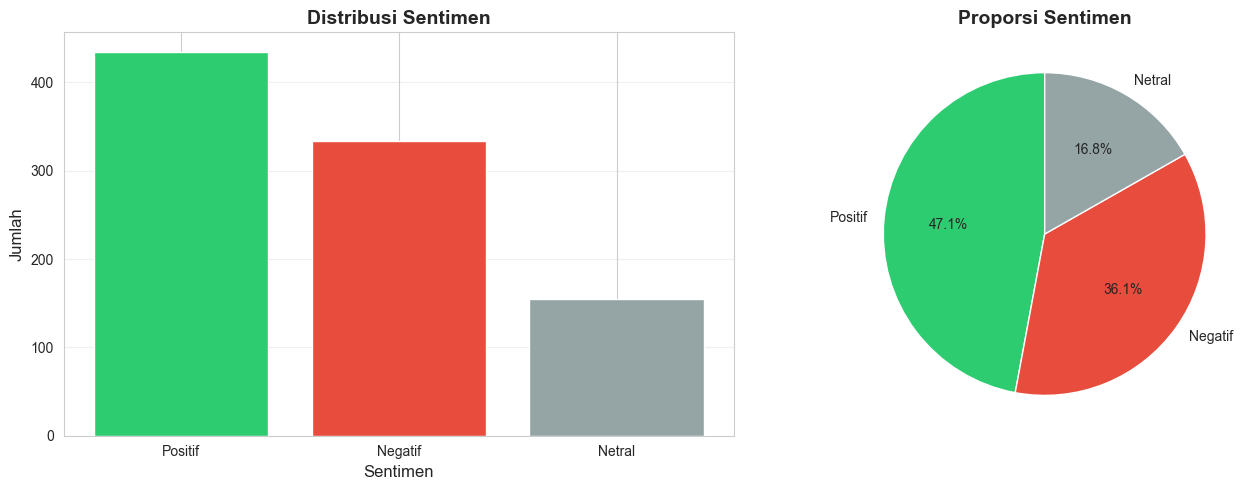

In [6]:
# Visualisasi distribusi sentimen
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
sentiment_counts = df['sentiment'].value_counts()
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['#2ecc71', '#e74c3c', '#95a5a6'])
axes[0].set_xlabel('Sentimen', fontsize=12)
axes[0].set_ylabel('Jumlah', fontsize=12)
axes[0].set_title('Distribusi Sentimen', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = ['#2ecc71', '#e74c3c', '#95a5a6']
axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Proporsi Sentimen', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Statistik Panjang Teks:
          word_count                                                      \
               count       mean        std  min   25%   50%   75%    max   
sentiment                                                                  
Negatif        334.0  24.916168  25.253528  3.0  11.0  17.0  28.0  193.0   
Netral         155.0  14.593548  16.369792  3.0   7.0  11.0  18.0  181.0   
Positif        435.0  15.517241  12.738293  2.0   8.0  12.0  20.0  120.0   

          char_count                                                     \
               count        mean         std   min   25%    50%     75%   
sentiment                                                                 
Negatif        334.0  155.479042  160.471821  17.0  68.0  106.0  171.75   
Netral         155.0   90.251613  104.711948  13.0  43.0   68.0  111.50   
Positif        435.0   96.885057   80.788143   9.0  47.0   74.0  122.00   

                   
              max  
sentiment          
Negatif 

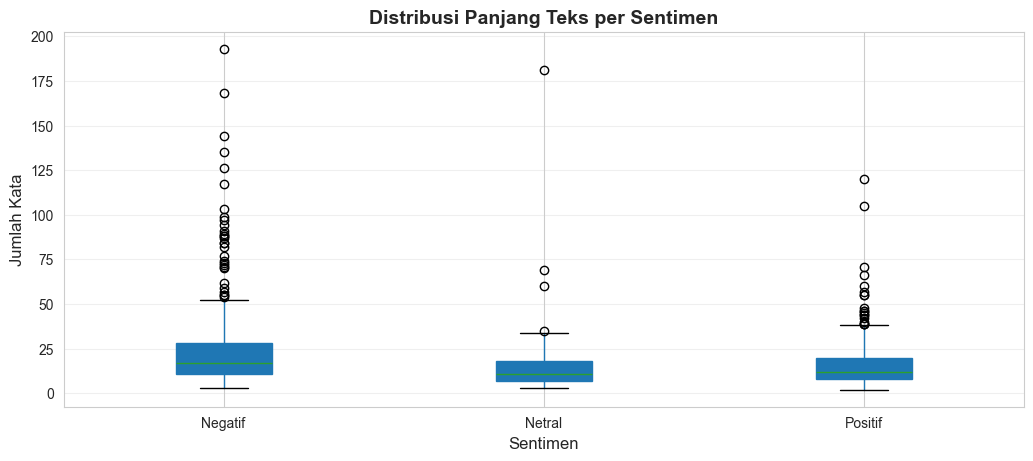

In [7]:
# Analisis panjang teks
df['word_count'] = df['comment'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['comment'].apply(lambda x: len(str(x)))

print("Statistik Panjang Teks:")
print(df.groupby('sentiment')[['word_count', 'char_count']].describe())

# Visualisasi distribusi panjang kata per sentimen
fig, ax = plt.subplots(figsize=(12, 5))
df.boxplot(column='word_count', by='sentiment', ax=ax, patch_artist=True)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Kata', fontsize=12)
plt.title('Distribusi Panjang Teks per Sentimen', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.grid(axis='y', alpha=0.3)
plt.show()

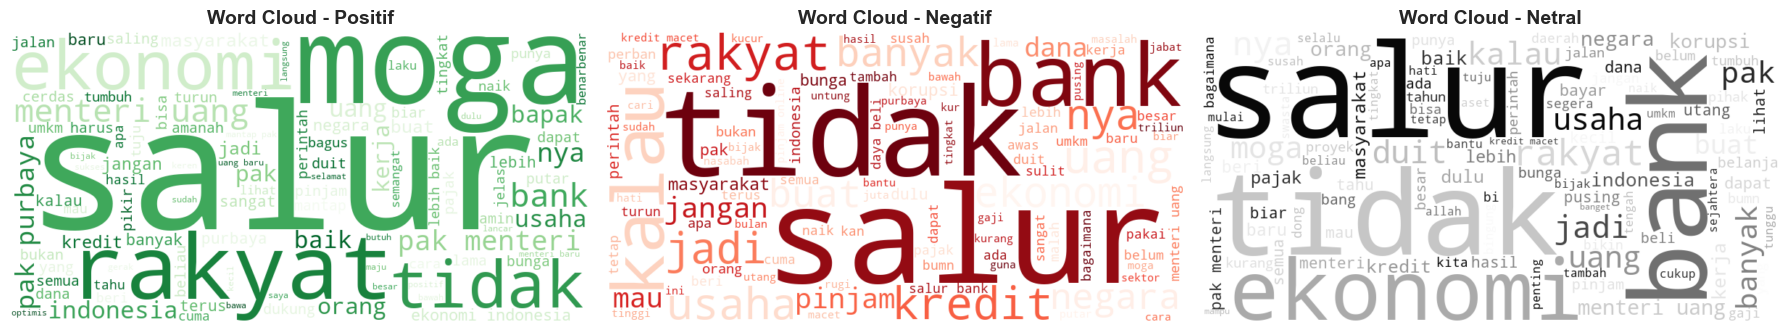

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sentiments = ['Positif', 'Negatif', 'Netral']
colors_wc = ['Greens', 'Reds', 'Greys']

for idx, (sentiment, cmap) in enumerate(zip(sentiments, colors_wc)):
    # Gabungkan semua komentar untuk sentimen tertentu
    text = ' '.join(df[df['sentiment'] == sentiment]['comment'].astype(str))
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap=cmap,
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(text)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud - {sentiment}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 4. Persiapan Data untuk Training
Split data menjadi training dan testing set.

In [8]:
# Pisahkan fitur dan label
X = df['comment']
y = df['sentiment']

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"\nDistribusi training set:")
print(y_train.value_counts())
print(f"\nDistribusi testing set:")
print(y_test.value_counts())

Training set: 739 samples
Testing set: 185 samples

Distribusi training set:
sentiment
Positif    348
Negatif    267
Netral     124
Name: count, dtype: int64

Distribusi testing set:
sentiment
Positif    87
Negatif    67
Netral     31
Name: count, dtype: int64


## 5. Feature Extraction dengan TF-IDF
Mengubah teks menjadi representasi numerik menggunakan TF-IDF.

In [9]:
# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # unigram dan bigram
    min_df=2,
    max_df=0.95
)

# Transform data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape:")
print(f"Training: {X_train_tfidf.shape}")
print(f"Testing: {X_test_tfidf.shape}")
print(f"\nJumlah fitur: {len(tfidf_vectorizer.get_feature_names_out())}")

TF-IDF matrix shape:
Training: (739, 2234)
Testing: (185, 2234)

Jumlah fitur: 2234


## 6. Classical Machine Learning dengan K-Fold Cross Validation
Training dan evaluasi model SVM dan XGBoost dengan hyperparameter tuning menggunakan K-Fold Cross Validation pada data training.

### 6.1 Support Vector Machine (SVM) dengan GridSearchCV

In [10]:
# Hyperparameter tuning untuk SVM menggunakan GridSearchCV dengan K-Fold CV
print("Memulai hyperparameter tuning untuk SVM...")
print("=" * 60)

# Define parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

# Setup K-Fold Cross Validation (hanya pada data training)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV untuk mencari parameter terbaik
svm_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=kfold,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Training dengan GridSearchCV (hanya pada data training)
svm_grid.fit(X_train_tfidf, y_train)

print("\n" + "=" * 60)
print("HASIL HYPERPARAMETER TUNING SVM")
print("=" * 60)
print(f"Best Parameters: {svm_grid.best_params_}")
print(f"Best Cross-Validation F1-Score: {svm_grid.best_score_:.4f}")
print("=" * 60)

# Model terbaik dari GridSearchCV
svm_model = svm_grid.best_estimator_


Memulai hyperparameter tuning untuk SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

HASIL HYPERPARAMETER TUNING SVM
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation F1-Score: 0.5573

HASIL HYPERPARAMETER TUNING SVM
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation F1-Score: 0.5573


In [11]:
# Evaluasi SVM pada test set (data yang tidak pernah dilihat model)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("\n" + "=" * 60)
print("SVM - EVALUASI PADA TEST SET")
print("=" * 60)
print(classification_report(y_test, y_pred_svm))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision (Weighted): {precision_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"Recall (Weighted): {recall_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")
print("=" * 60)


SVM - EVALUASI PADA TEST SET
              precision    recall  f1-score   support

     Negatif       0.63      0.78      0.70        67
      Netral       0.26      0.23      0.24        31
     Positif       0.76      0.67      0.71        87

    accuracy                           0.63       185
   macro avg       0.55      0.56      0.55       185
weighted avg       0.63      0.63      0.63       185


Accuracy: 0.6324
Precision (Weighted): 0.6320
Recall (Weighted): 0.6324
F1-Score (Weighted): 0.6279


### 6.2 XGBoost dengan GridSearchCV

In [19]:
# Encode labels untuk XGBoost (harus numerik)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Memulai hyperparameter tuning untuk XGBoost...")
print("=" * 60)

# Define parameter grid
param_grid_xgb = {
    'max_depth': [3, 5, 6],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# GridSearchCV untuk XGBoost
xgb_grid = RandomizedSearchCV(
    XGBClassifier(
        random_state=42,
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1
    ),
    param_grid_xgb,
    n_iter=100,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=2
)


# Training dengan GridSearchCV (hanya pada data training)
xgb_grid.fit(X_train_tfidf, y_train_encoded)

print("\n" + "=" * 60)
print("HASIL HYPERPARAMETER TUNING XGBOOST")
print("=" * 60)
print(f"Best Parameters: {xgb_grid.best_params_}")
print(f"Best Cross-Validation F1-Score: {xgb_grid.best_score_:.4f}")
print("=" * 60)

# Model terbaik dari GridSearchCV
xgb_model = xgb_grid.best_estimator_

Memulai hyperparameter tuning untuk XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

HASIL HYPERPARAMETER TUNING XGBOOST
Best Parameters: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
Best Cross-Validation F1-Score: 0.6230

HASIL HYPERPARAMETER TUNING XGBOOST
Best Parameters: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
Best Cross-Validation F1-Score: 0.6230


In [20]:
# Evaluasi XGBoost pada test set
y_pred_xgb_encoded = xgb_model.predict(X_test_tfidf)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

print("\n" + "=" * 60)
print("XGBOOST - EVALUASI PADA TEST SET")
print("=" * 60)
print(classification_report(y_test, y_pred_xgb))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision (Weighted): {precision_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"Recall (Weighted): {recall_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print("=" * 60)


XGBOOST - EVALUASI PADA TEST SET
              precision    recall  f1-score   support

     Negatif       0.63      0.64      0.64        67
      Netral       0.22      0.13      0.16        31
     Positif       0.65      0.74      0.69        87

    accuracy                           0.60       185
   macro avg       0.50      0.50      0.50       185
weighted avg       0.57      0.60      0.58       185


Accuracy: 0.6000
Precision (Weighted): 0.5703
Recall (Weighted): 0.6000
F1-Score (Weighted): 0.5817


### 6.3 Confusion Matrix untuk Classical ML Models

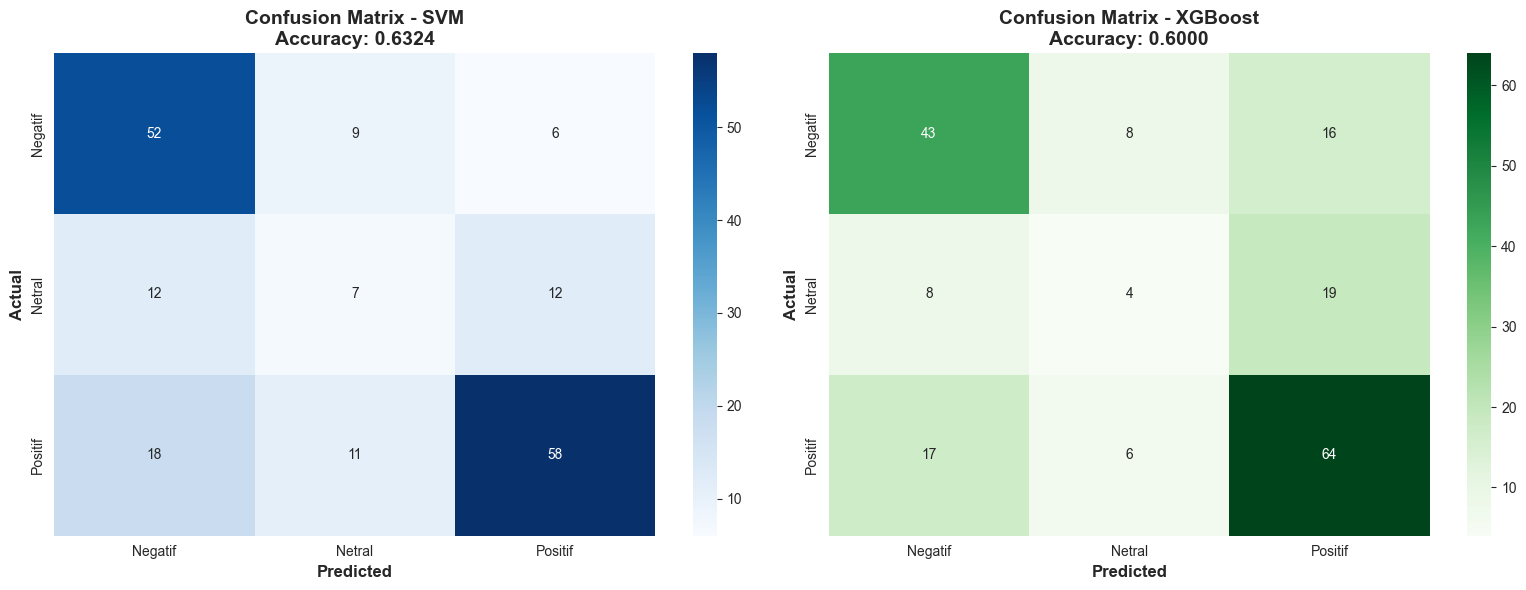

In [21]:
# Visualisasi Confusion Matrix untuk SVM dan XGBoost
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[0].set_title(f'Confusion Matrix - SVM\nAccuracy: {accuracy_score(y_test, y_pred_svm):.4f}', 
                  fontsize=14, fontweight='bold')

# Confusion Matrix XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[1].set_title(f'Confusion Matrix - XGBoost\nAccuracy: {accuracy_score(y_test, y_pred_xgb):.4f}', 
                  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Perbandingan Model SVM dan XGBoost
Membandingkan performa SVM dan XGBoost.

In [22]:
# Kumpulkan hasil evaluasi kedua model
models = ['SVM (K-Fold CV)', 'XGBoost (K-Fold CV)']
predictions = [y_pred_svm, y_pred_xgb]

results = []
for model_name, y_pred in zip(models, predictions):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_weighted
    })

results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("\n" + "=" * 80)
print("PERBANDINGAN PERFORMA MODEL SVM DAN XGBOOST")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)


PERBANDINGAN PERFORMA MODEL SVM DAN XGBOOST
              Model  Accuracy  Precision  Recall  F1-Score
    SVM (K-Fold CV)    0.6324     0.6320  0.6324    0.6279
XGBoost (K-Fold CV)    0.6000     0.5703  0.6000    0.5817


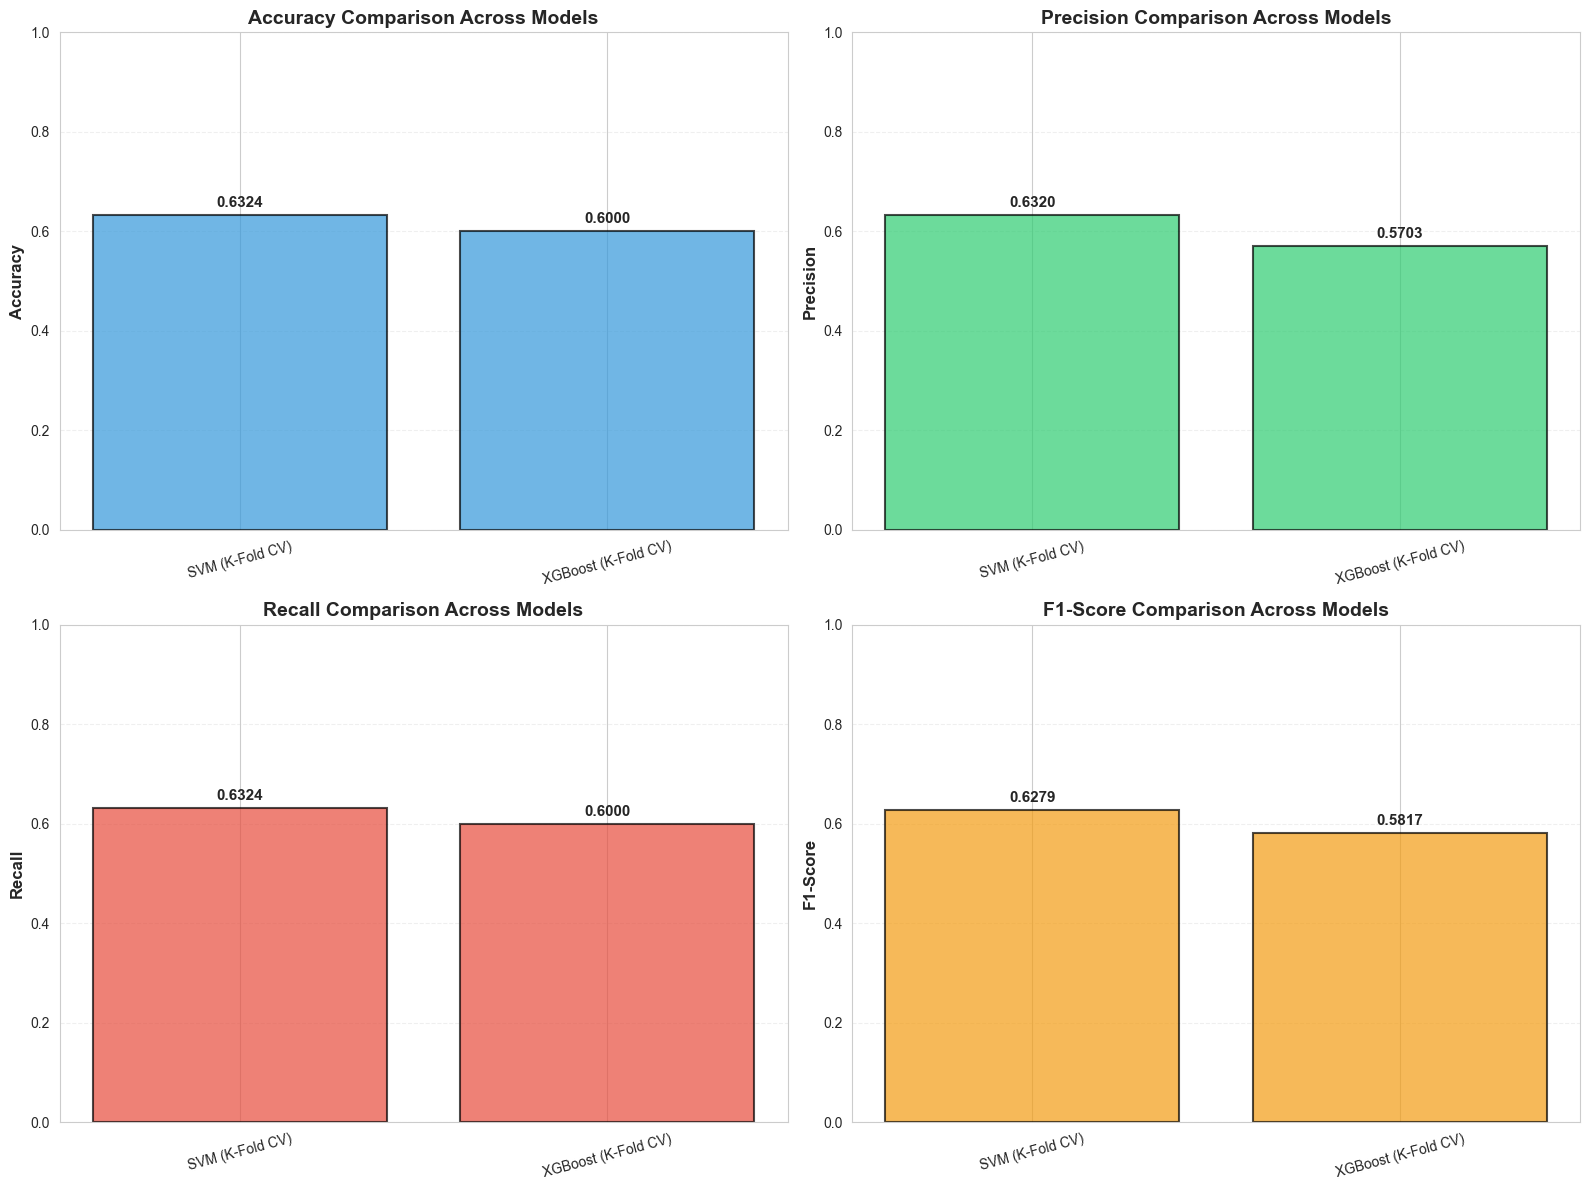

In [23]:
# Visualisasi perbandingan model - Bar Chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (ax, metric, color) in enumerate(zip(axes.flatten(), metrics, colors)):
    bars = ax.bar(results_df['Model'], results_df[metric], color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison Across Models', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='x', rotation=15, labelsize=10)
    
    # Tambahkan nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

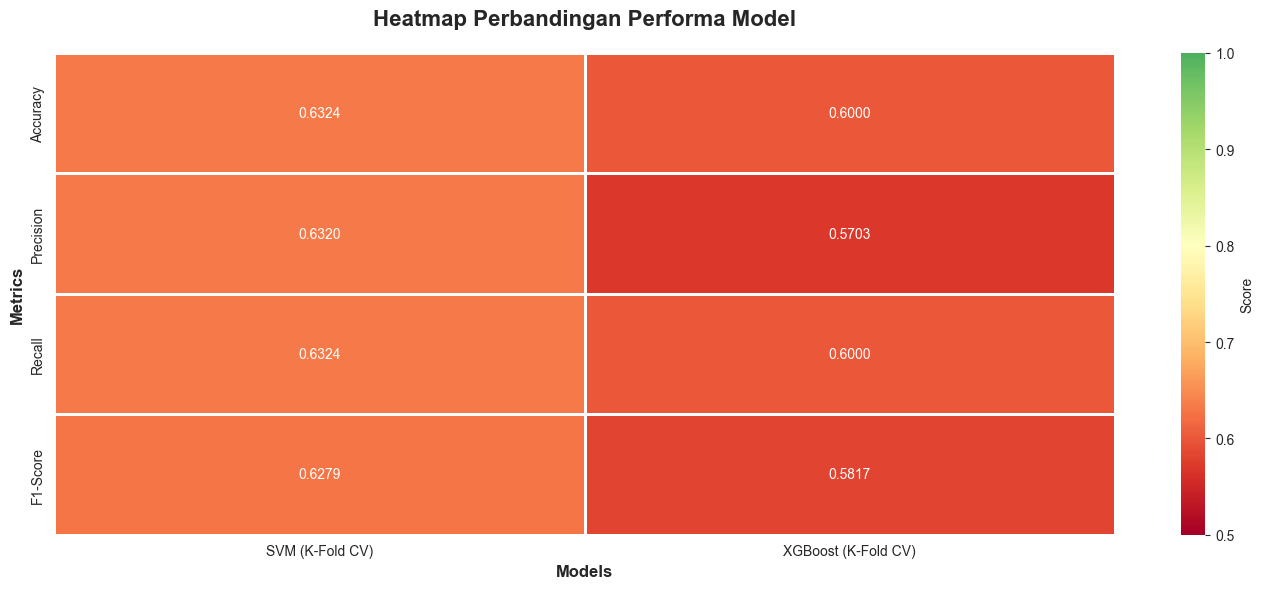

In [24]:
# Heatmap perbandingan semua metrik
plt.figure(figsize=(14, 6))
sns.heatmap(results_df.set_index('Model').T, annot=True, fmt='.4f', 
            cmap='RdYlGn', center=0.8, vmin=0.5, vmax=1.0, 
            cbar_kws={'label': 'Score'}, linewidths=2, linecolor='white')
plt.title('Heatmap Perbandingan Performa Model', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Metrics', fontsize=12, fontweight='bold')
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Model Terbaik dan Kesimpulan

In [25]:
# Tentukan model terbaik berdasarkan F1-Score
best_model_idx = results_df['F1-Score'].idxmax()
best_model = results_df.loc[best_model_idx]

print("\n" + "=" * 80)
print("MODEL TERBAIK BERDASARKAN F1-SCORE")
print("=" * 80)
print(f"Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")
print("=" * 80)

print("\n" + "=" * 80)
print("RANGKUMAN METODOLOGI")
print("=" * 80)
print("1. Classical Machine Learning (SVM & XGBoost):")
print("   - Representasi Fitur: TF-IDF (max_features=5000, ngram_range=(1,2))")
print("   - Optimasi: GridSearchCV dengan 5-Fold Stratified Cross Validation")
print("   - Evaluasi: Test set terpisah (tidak terlihat saat training)")
print("\n2. Metrik Evaluasi:")
print("   - Accuracy, Precision, Recall, F1-Score (Weighted)")
print("   - Confusion Matrix")
print("\n3. Hasil:")
print(f"   - Model terbaik: {best_model['Model']}")
print(f"   - F1-Score: {best_model['F1-Score']:.4f}")
print("=" * 80)


MODEL TERBAIK BERDASARKAN F1-SCORE
Model: SVM (K-Fold CV)
Accuracy: 0.6324
Precision: 0.6320
Recall: 0.6324
F1-Score: 0.6279

RANGKUMAN METODOLOGI
1. Classical Machine Learning (SVM & XGBoost):
   - Representasi Fitur: TF-IDF (max_features=5000, ngram_range=(1,2))
   - Optimasi: GridSearchCV dengan 5-Fold Stratified Cross Validation
   - Evaluasi: Test set terpisah (tidak terlihat saat training)

2. Metrik Evaluasi:
   - Accuracy, Precision, Recall, F1-Score (Weighted)
   - Confusion Matrix

3. Hasil:
   - Model terbaik: SVM (K-Fold CV)
   - F1-Score: 0.6279


In [26]:
# Simpan hasil perbandingan ke CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nHasil perbandingan berhasil disimpan ke: model_comparison_results.csv")


Hasil perbandingan berhasil disimpan ke: model_comparison_results.csv


## 9. Simpan Model

In [30]:
import joblib
import pickle

# Buat direktori models jika belum ada
import os
os.makedirs('models', exist_ok=True)

# Simpan model classical ML
joblib.dump(svm_model, 'models/svm_model.pkl')
joblib.dump(xgb_model, 'models/xgboost_model.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')

# Simpan label encoder
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Simpan hasil GridSearchCV
with open('models/svm_best_params.pkl', 'wb') as f:
    pickle.dump(svm_grid.best_params_, f)
with open('models/xgb_best_params.pkl', 'wb') as f:
    pickle.dump(xgb_grid.best_params_, f)

print("\n" + "=" * 60)
print("SEMUA MODEL BERHASIL DISIMPAN!")
print("=" * 60)
print("Lokasi:")
print("- SVM Model: models/svm_model.pkl")
print("- XGBoost Model: models/xgboost_model.pkl")
print("- TF-IDF Vectorizer: models/tfidf_vectorizer.pkl")
print("- Label Encoder: models/label_encoder.pkl")
print("- Best Parameters:")
print("  * SVM: models/svm_best_params.pkl")
print("  * XGBoost: models/xgb_best_params.pkl")
print("=" * 60)


SEMUA MODEL BERHASIL DISIMPAN!
Lokasi:
- SVM Model: models/svm_model.pkl
- XGBoost Model: models/xgboost_model.pkl
- TF-IDF Vectorizer: models/tfidf_vectorizer.pkl
- Label Encoder: models/label_encoder.pkl
- Best Parameters:
  * SVM: models/svm_best_params.pkl
  * XGBoost: models/xgb_best_params.pkl
